In [158]:
from scipy.io import loadmat
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


%matplotlib inline

In [36]:
filelist = ["calcium_data/140708B_140811a_result", 
            "calcium_data/140909C_141112a_result", 
            "calcium_data/141006C_141121a_result",
            "calcium_data/150109A_150302a_result", 
            "calcium_data/151122A_160202a_result", 
            "calcium_data/151122B_160207a_result", 
            "calcium_data/160209A_160430a_result", 
            "calcium_data/160209B_160428a_result"]

In [37]:
filename = filelist[0]
f = h5py.File(filename+".hdf5", "r")

In [139]:
amp = 2
site = 46

#average delta F
#1s = 58 frames
data = f['data']
meta = f['meta']

mn_dnd_chng = np.mean(data[:,:,58:116], axis=2)

present_mask = meta[:,1]==amp
absent_mask = meta[:,1]==0
    
trials_mask = np.logical_or(present_mask, absent_mask)
    
y_score = mn_dnd_chng[trials_mask, site]
    
amp_mask = meta[:,1][trials_mask]==amp
y_true = (amp_mask-0.5)*2

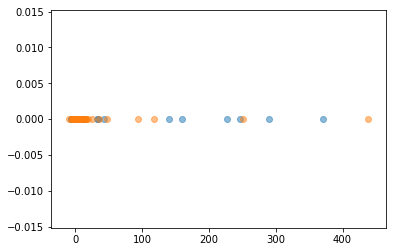

In [140]:
plt.scatter(y_score[y_true==1], np.zeros(y_score[y_true==1].shape[0]), alpha=0.5)
plt.scatter(y_score[y_true==-1], np.zeros(y_score[y_true==-1].shape[0]), alpha=0.5)

In [141]:
X_train, X_test, y_train, y_test = train_test_split(y_score, y_true, test_size=0.33)

In [142]:
clf = svm.SVC()
clf.fit(X_train.reshape(X_train.shape[0], 1), y_train.reshape(y_train.shape[0], 1))

/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [143]:
pred = clf.predict(X_test.reshape(X_test.shape[0], 1))
params = clf.get_params()
print(pred)
print(y_test)
print(np.sum(pred == y_test)/y_test.shape[0])

[-1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1.
 -1. -1.  1. -1.  1. -1.  1. -1. -1. -1. -1. -1.  1. -1.  1.]
[ 1.  1. -1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1. -1. -1.  1.  1.  1.
  1.  1. -1.  1.  1. -1. -1. -1.  1. -1.  1. -1. -1. -1.  1.]
0.393939393939


In [64]:
params

{'C': 1.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': None,
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [150]:
amp = 2

#average delta F
#1s = 58 frames
data = f['data']
meta = f['meta']

mn_dnd_chng = np.mean(data[:,:,58:116], axis=2)

present_mask = meta[:,1]==amp
absent_mask = meta[:,1]==0
    
trials_mask = np.logical_or(present_mask, absent_mask)
    
y_score = mn_dnd_chng[trials_mask, :]
    
amp_mask = meta[:,1][trials_mask]==amp
y_true = (amp_mask-0.5)*2

In [151]:
X_train, X_test, y_train, y_test = train_test_split(y_score, y_true, test_size=0.33)

In [152]:
clf = svm.SVC(kernel='poly')
clf.fit(X_train, y_train.reshape(y_train.shape[0], 1))

/home/georg/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [153]:
pred = clf.predict(X_test)
params = clf.get_params()
print(pred)
print(y_test)
print(np.sum(pred == y_test)/y_test.shape[0])

[ 1.  1. -1.  1.  1.  1.  1.  1. -1.  1.  1. -1.  1. -1.  1. -1. -1. -1.
 -1.  1.  1.  1.  1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1.]
[ 1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1.  1.  1. -1.  1.  1. -1. -1.
  1. -1. -1.  1.  1. -1. -1.  1. -1. -1.  1.  1. -1.  1. -1.]
0.727272727273


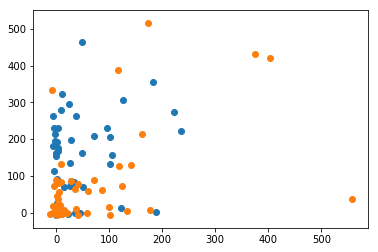

In [156]:
dim1 = np.random.randint(100)
dim2 = np.random.randint(100)
plt.scatter(y_score[:,dim1][y_true==1], y_score[:,dim2][y_true==1])
plt.scatter(y_score[:,dim1][y_true==-1], y_score[:,dim2][y_true==-1])

In [163]:
y_score.shape

(100, 115)

In [172]:
filename =filelist[0]
amp = 2
test_size = 0.33
svm_kernel = 'linear'

n_dendrites = h5py.File(filename+".hdf5", "r")['data'].shape[1]

clf = svm.SVC(kernel=svm_kernel)

means = []
stds = []
for site in range(n_dendrites):

    data = f['data']
    meta = f['meta']

    mn_dnd_chng = np.mean(data[:,:,58:116], axis=2)

    present_mask = meta[:,1]==amp
    absent_mask = meta[:,1]==0

    trials_mask = np.logical_or(present_mask, absent_mask)

    y_score = mn_dnd_chng[trials_mask, site]

    amp_mask = meta[:,1][trials_mask]==amp
    y_true = (amp_mask-0.5)*2
    
    X_train, X_test, y_train, y_test = train_test_split(y_score, y_true, test_size=test_size)
    
    #clf.fit(X_train.reshape(X_train.shape[0], 1), y_train.reshape(y_train.shape[0], 1))
    scores = cross_val_score(clf, X_train.reshape(X_train.shape[0], 1), y_train.reshape(y_train.shape[0]), cv=5)
    mean = scores.mean()
    stdv = scores.std()
    means.append(mean)
    stds.append(stdv)
                             
    print("For recording site {0}: accuracy: {1: .2f} (+/- {2: .2f})".format(site, mean, stdv*2))

For recording site 0: accuracy:  0.52 (+/-  0.04)
For recording site 1: accuracy:  0.53 (+/-  0.23)
For recording site 2: accuracy:  0.48 (+/-  0.10)
For recording site 3: accuracy:  0.52 (+/-  0.06)
For recording site 4: accuracy:  0.55 (+/-  0.08)
For recording site 5: accuracy:  0.51 (+/-  0.06)
For recording site 6: accuracy:  0.54 (+/-  0.08)
For recording site 7: accuracy:  0.55 (+/-  0.11)
For recording site 8: accuracy:  0.46 (+/-  0.10)
For recording site 9: accuracy:  0.51 (+/-  0.03)
For recording site 10: accuracy:  0.55 (+/-  0.10)
For recording site 11: accuracy:  0.60 (+/-  0.06)
For recording site 12: accuracy:  0.48 (+/-  0.06)
For recording site 13: accuracy:  0.51 (+/-  0.09)
For recording site 14: accuracy:  0.49 (+/-  0.12)
For recording site 15: accuracy:  0.52 (+/-  0.06)
For recording site 16: accuracy:  0.54 (+/-  0.00)
For recording site 17: accuracy:  0.46 (+/-  0.15)
For recording site 18: accuracy:  0.55 (+/-  0.08)
For recording site 19: accuracy:  0.54 (+

(0, 1)

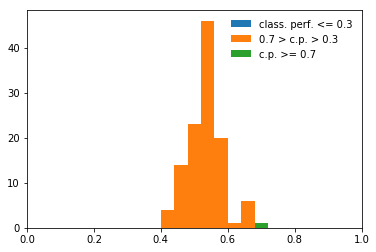

In [182]:
means = np.asarray(means)

lo_mask = means <= 0.3
mid_mask = np.logical_and(means >0.3, means < 0.7)
hi_mask = means >= 0.7

plt.hist(means[lo_mask], bins=50, range=(-1,1), label='class. perf. <= 0.3')
plt.hist(means[mid_mask], bins=50, range=(-1,1), label='0.7 > c.p. > 0.3')
plt.hist(means[hi_mask], bins=50, range=(-1,1), label='c.p. >= 0.7')
plt.legend(frameon=False)
plt.xlim(0,1)